Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


**You can't just copy** from the lesson notebook to this assignment.

- Because the lesson was **regression**, but the assignment is **classification.**
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

#I. Wrangle

In [4]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [46]:
#apply the wrangle function to the test and train sets
train_df = wrangle(train)

In [48]:
test_df = wrangle(test)

#II. Split Data

In [7]:
target = 'status_group'
X_train = train_df.drop('status_group', axis = 1)
y_train = train_df['status_group']

#Since we are doing K-fold validation, we don't need to manually create a validation set

In [49]:
X_test = test_df

#III. Build Model

In [11]:
#Import statements
#Since we are doing classification, not regression, we will import the machinery needed for Random Forest
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.model_selection import cross_val_score

rf_model = make_pipeline(ce.OrdinalEncoder(),
                   SimpleImputer(),
                   RandomForestClassifier(random_state=42))


In [13]:

rfmodel_cvs = cross_val_score(rf_model, X_train, y_train, cv=5, n_jobs=-1)

In [14]:
print("random forest classifier:")
print("cross validation score series is", rfmodel_cvs)
print("cross validation score mean is", rfmodel_cvs.mean())
print("cross validation score standard deviation is", rfmodel_cvs.std())

random forest classifier:
cross validation score series is [0.80959596 0.80824916 0.80580808 0.80673401 0.80462963]
cross validation score mean is 0.807003367003367
cross validation score standard deviation is 0.0017555298540375516


#IV. Tune Model

In [15]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np


In [20]:
#setting some hyper-parameters to be modified
paras = {'randomforestclassifier__n_estimators': np.arange(20, 65, 22), 
         'randomforestclassifier__max_depth': np.arange(10, 31, 10),
         'randomforestclassifier__max_samples': np.arange(0.3, 0.71, 0.2)}

rf_gs = GridSearchCV(rf_model, paras, cv=5, n_jobs=-1, verbose=1)

In [21]:
rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  6.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=None,
                                                       drop_invariant=False,
                                                       handle_missing='value',
                                                       handle_unknown='value',
                                                       mapping=None,
                                                       return_df=True,
                                                       verbose=0)),
                                       ('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
          

In [22]:
pd.DataFrame(rf_gs.cv_results_).sort_values(by='mean_test_score', ascending=False).T

,26,17,16,25,23,14,22,13,20,11,15,19,10,24,12,21,9,18,8,5,7,4,6,2,3,1,0
mean_fit_time,10.312,9.84584,6.87575,7.24639,8.56347,8.03116,6.02736,5.68574,6.2223,5.98173,3.83854,4.4995,4.36009,4.12615,3.37063,3.50291,2.72293,2.72087,7.02468,5.76632,4.89332,4.19232,2.95125,4.54014,2.64512,3.43403,2.25096
std_fit_time,0.574822,0.10227,0.0700995,0.105621,0.139591,0.0882066,0.0969921,0.0481937,0.0689739,0.0510735,0.0711767,0.0353335,0.055479,0.0834412,0.05755,0.0435498,0.0234612,0.0412382,0.0791371,0.0499826,0.0542196,0.0819824,0.0375367,0.0855142,0.08026,0.0364709,0.0679607
mean_score_time,0.397061,0.387976,0.352625,0.339467,0.409287,0.38174,0.303286,0.288107,0.367797,0.362775,0.243695,0.299078,0.300438,0.237897,0.215961,0.219164,0.237263,0.248459,0.2928,0.263177,0.230238,0.223912,0.186679,0.270676,0.182151,0.229526,0.196209
std_score_time,0.0506361,0.0323267,0.055166,0.0257794,0.0350918,0.0338588,0.0107408,0.00972042,0.0158958,0.0137676,0.030109,0.00979818,0.0284343,0.0147759,0.0103289,0.00247101,0.0511995,0.0391505,0.0413646,0.0059982,0.0116861,0.0065677,0.0048925,0.0141831,0.00696172,0.00947787,0.0241855
param_randomforestclassifier__max_depth,30,20,20,30,30,20,30,20,30,20,20,30,20,30,20,30,20,30,10,10,10,10,10,10,10,10,10
param_randomforestclassifier__max_samples,0.7,0.7,0.7,0.7,0.5,0.5,0.5,0.5,0.3,0.3,0.7,0.3,0.3,0.7,0.5,0.5,0.3,0.3,0.7,0.5,0.7,0.5,0.7,0.3,0.5,0.3,0.3
param_randomforestclassifier__n_estimators,64,64,42,42,64,64,42,42,64,64,20,42,42,20,20,20,20,20,64,64,42,42,20,64,20,42,20
params,"{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran..."
split0_test_score,0.814141,0.814646,0.811869,0.811953,0.81532,0.809428,0.811616,0.807323,0.809091,0.808923,0.803367,0.805303,0.80463,0.800589,0.799495,0.802273,0.796296,0.794108,0.774495,0.772306,0.772222,0.771296,0.76936,0.769697,0.768939,0.767088,0.764394
split1_test_score,0.809343,0.808418,0.805303,0.808165,0.804882,0.806734,0.803872,0.803199,0.800337,0.800758,0.802862,0.799158,0.798485,0.796465,0.794781,0.796128,0.79234,0.793182,0.756734,0.758586,0.755135,0.756818,0.756818,0.756061,0.754377,0.752357,0.757323


In [23]:
rf_gs.best_estimator_

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=30, max_features='auto',
                                 

In [24]:
rf_gs.best_score_

0.8101683501683501

In [25]:
rf_gs.best_params_

{'randomforestclassifier__max_depth': 30,
 'randomforestclassifier__max_samples': 0.7,
 'randomforestclassifier__n_estimators': 64}

In [ ]:
#Let's try the same with randomized search


In [26]:
rf_rs = RandomizedSearchCV(rf_model, param_distributions=paras, n_iter=3, cv=5, n_jobs=-1, verbose=1)

In [27]:
rf_rs.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   44.9s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [28]:
rf_rs.best_score_

0.8054377104377103

In [ ]:
#Lower than our grid search, but much faster

#V. Visualize

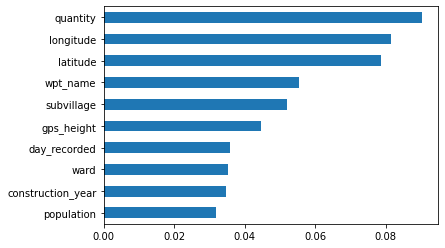

In [31]:
importances = rf_gs.best_estimator_.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh')

#VI. Kaggle

In [50]:
X_test = wrangle(test)
# # Makes a dataframe with two columns, id and status_group, 
# # and writes to a csv file, without the index

y_pred = rf_gs.predict(X_test)

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('your-submission-filename.csv', index=False)

In [51]:
submission

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,functional
14356,33492,functional


In [52]:
submission.to_csv('2020-01-20_kaggle_submission.csv', index=False)